# 0.0 Imports

In [104]:
import umap.umap_        as umap
import numpy             as np
import pandas            as pd
import seaborn           as sns
import re


from matplotlib         import pyplot           as plt 
%matplotlib inline
from plotly             import express          as px

from sklearn            import cluster as c 
from sklearn            import metrics as m
from sklearn            import decomposition    as dd
from sklearn.manifold   import TSNE
from sklearn            import ensemble         as en
from sklearn            import preprocessing    as pp
from sklearn            import manifold         as mn
from sklearn            import metrics          as m
from sklearn            import mixture          as mx
from scipy.cluster      import hierarchy        as hc 


## 0.1 Load Dataset 

In [105]:
#load dataset
df_raw = pd.read_csv('Ecommerce.csv')

#drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [106]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Description data

In [107]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [108]:
df1.columns 

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [109]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Dimensions

In [110]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [111]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [112]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [115]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [116]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no']).drop_duplicates()
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

#merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [117]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [118]:
#invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y') 

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7 Descriptive Statistics

In [119]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [120]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m1 = pd.concat([d2 ,d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1 = m1.drop([2])
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097



- need investige negative quantity, could be return 
- unit price equal zero, could be sale

### 7.1.2 Categorical Attributes

In [121]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### Invoice number 

In [122]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

#check if the number of invoices that contains letters are igual with negative quantity
print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


##### Stock code

In [123]:
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [124]:
df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


##### Country

In [125]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [126]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Filter Variables

In [127]:
df2 = df1.copy()

In [130]:
#unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code different of ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#description
df2 = df2.drop(columns='description', axis=1)

#map 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad users
df2 = df2[~df2['customer_id'].isin([16446])] #user com numero muito grande de retornos 

#quantity - dividing in return and purchase 
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [132]:
df3 = df2.copy()

## 3.1 Feature Creation 

In [133]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date','unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [134]:
# Gross Revenue
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

#Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

C:\Users\aline\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\aline\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.2 Recency - Days from last purchase

In [135]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2.invoice_date.max() - df_recency.invoice_date).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3 Quantity purchased 

In [136]:
# Numero de vezes que foi ao mercado
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.4 Quantity total of items purchased 

In [137]:
#quantidade de items comprados durante todo esse tempo 
df_freq = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_items'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.5 Quantity of products purchased

In [138]:
df_freq = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.5 Average Ticket Value 

In [139]:
# average ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

### Frequency Purchase

In [140]:
df_aux = ( df2_purchases[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates()
                                                  .groupby('customer_id')
                                                  .agg(max_ = ('invoice_date', 'max'),
                                                      min_ = ('invoice_date', 'min'),
                                                      days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                      buys_ = ('invoice_no', 'count')) ).reset_index()

#Frequency
df_aux['frequency'] = df_aux[['buys_', 'days_']].apply(lambda x: x['buys_'] / x['days_'] if x['days_'] !=0 else 0, axis=1)
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

### Number of Returns

In [141]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

### Basket Size - Quantidade de items por cesta (Quantity)

In [142]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                          .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                               n_products = ('quantity', 'sum')).reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')

### Unique Basket Size - Quantidade de Itens por Cesta (Stock_code)

In [143]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                          .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                               n_products = ('stock_code', 'nunique')).reset_index() )

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
qtde_invoices             91
qtde_items                91
qtde_products             91
avg_ticket                91
frequency                 91
qtde_returns               0
avg_basket_size           91
avg_unique_basket_size    91
dtype: int64

# 4.0 EDA (Exploratory Data Analysis)

In [144]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [145]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,0.073171,22.0,26.666667,0.333333


### 4.1 Univariate Analysis

In [146]:
#central tendency - mean, median
ct1 = pd.DataFrame(round(df4.apply(np.mean),2)).T
ct2 = pd.DataFrame(round(df4.apply(np.median),2)).T

#dispersion 
d1 = pd.DataFrame(round(df4.apply(np.std),2)).T
d2 = pd.DataFrame(round(df4.apply(np.min),2)).T
d3 = pd.DataFrame(round(df4.apply(np.max),2)).T
d4 = pd.DataFrame(round(df4.apply(lambda x: x.max() - x.min()),2)).T
d5 = pd.DataFrame(round(df4.apply(lambda x: x.std()/x.mean()),2)).T


#concatenate
m = pd.concat([d2 ,d3, d4, ct1, ct2, d1, d5]).T.reset_index()
m = m.drop([0])
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'CV'  ]
m

,attributes,min,max,range,mean,median,std,CV
1,gross_revenue,0.42,279138.02,279137.60,1774.24,613.20,7581.44,4.27
2,recency_days,0.00,373.00,373.00,116.93,71.00,111.64,0.95
3,qtde_invoices,1.00,206.00,205.00,3.47,1.00,6.81,1.96
4,qtde_items,1.00,196844.00,196843.00,962.92,316.00,4296.37,4.46
5,qtde_products,1.00,7837.00,7836.00,92.60,41.00,210.52,2.27
6,avg_ticket,0.42,77183.60,77183.18,44.75,15.86,1043.71,23.32
7,frequency,0.01,17.00,16.99,0.55,1.00,0.55,1.01
8,qtde_returns,0.00,74215.00,74215.00,31.27,0.00,1004.23,32.12
9,avg_basket_size,1.00,74215.00,74214.00,260.61,151.25,1073.89,4.12
10,avg_unique_basket_size,0.20,1109.00,1108.80,37.25,15.00,76.88,2.06


#### 4.1.2 Gross Revenue

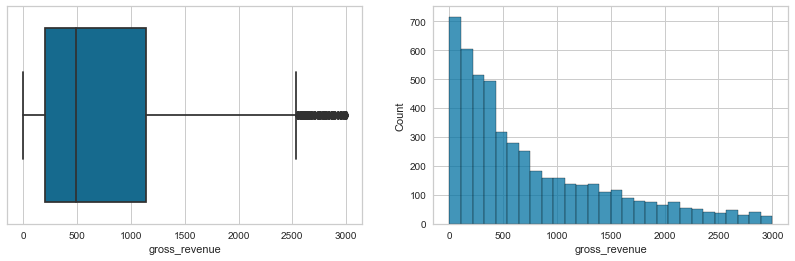

In [147]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=df4[df4['gross_revenue'] < 3000], x='gross_revenue')

plt.subplot(1, 2, 2)
sns.histplot(data=df4[df4['gross_revenue'] < 3000], x='gross_revenue')
plt.show()

In [148]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,0.127778,952.0,1521.586957,2.695652
66,14911,140438.72,1.0,199.0,79963.0,5670.0,24.768734,0.533512,3332.0,401.824121,8.969849
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,0.063694,427.0,3868.650000,22.150000


#### 4.1.3 Recency days

- muitas pessoas que faz pouco tempo que elas compraram, muitos compram com uma recencia de 7 dias (olhando o histograma)
- 50% dos clientes compraram em 30 dias (olhando a mediana)

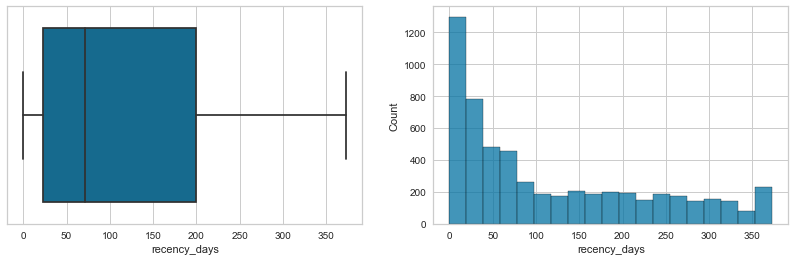

In [149]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=df4, x='recency_days')

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='recency_days')
plt.show()

#### 4.1.4 Quantidade de invoices
 - muitas pessoas fizeram poucas compras, muitas pessoas só compraram 2 vezes

#### Qtde Itens

In [150]:
df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,0.20339,288.0,2733.944444,9.708333


In [151]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


#### 4.1.4 Avg. Ticket

In [152]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [153]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


## 4.2 Bivariate Analysis

In [154]:
#cols = ['customer_id']
#df4_2 = df4.drop(cols, axis=1)

In [155]:
#plt.figure(figsize=(25, 12))
#sns.pairplot(df4_2);

## 4.3 Estudo do Espaço

In [171]:
#selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].drop(columns='customer_id', axis=1)

In [172]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']            = mm.fit_transform(df43[['recency_days']])
df43['qtde_products']          = mm.fit_transform(df43[['qtde_products']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])

X = df43.copy()
X.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0.019312,0.997319,0.037774,1.000000,0.000539
1,0.011579,0.150134,0.021695,0.001345,0.000472
2,0.024020,0.005362,0.029479,0.002052,0.000674
3,0.003396,0.254692,0.003446,0.000734,0.000000
4,0.003137,0.892761,0.000255,0.003985,0.000296


### 4.3.1 PCA 

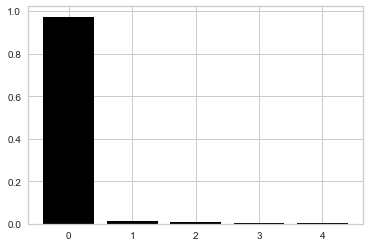

In [173]:
pca = dd.PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

#plot explained variables
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame(principal_components)

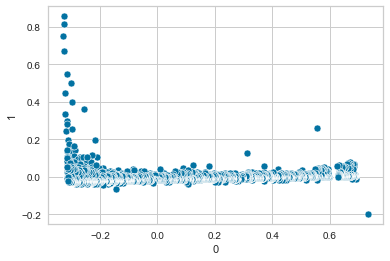

In [220]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

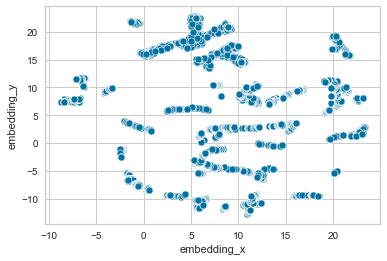

In [174]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)

### 4.3.3 T-SNE

C:\Users\aline\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aline\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

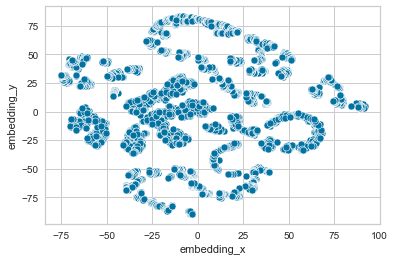

In [175]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42) 
embedding = reducer.fit_transform(X)

#embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne)

### 4.3.4 Tree-Based Embedding

In [176]:
X = df43.drop(columns=['gross_revenue'], axis=1)
y = df43['gross_revenue']

rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42) #sao criadas 100 arvores 

rf_model.fit(X,y)

df_leaf = pd.DataFrame(rf_model.apply(X))

In [177]:
df_leaf.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6432,6891,6931,6401,6582,6822,6858,6939,6955,6504,...,6925,6521,7008,6720,6705,6646,6497,6534,6568,6835
1,6402,6190,6372,6307,6367,6550,6344,5648,6862,6319,...,6336,6295,6889,6325,6201,6205,6326,6403,6404,6528
2,5392,6461,6831,6391,6528,6765,6312,6829,6820,6917,...,6437,6406,6908,5707,6302,6582,6451,6372,6538,6775
3,2788,498,891,547,412,630,990,510,930,679,...,1235,697,857,539,962,726,631,1088,541,339
4,526,207,512,844,595,1684,500,967,1323,471,...,411,956,456,782,530,74,541,82,688,1557


C:\Users\aline\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

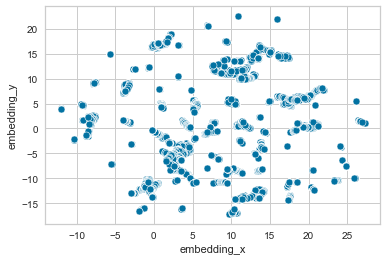

In [178]:
#reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)

# 5.0 Data Preparation

# 7.0 Hypermarameter Fine-Tunning

In [181]:
X = df_tree.copy()

In [182]:
X.head()

,embedding_x,embedding_y
0,12.932047,14.670385
1,7.626834,11.938689
2,12.472446,14.325506
3,-3.743209,7.794079
4,20.547087,-8.334893


In [183]:
clusters = np.arange(2,25,1)

## 7.1 K-Means

In [185]:
kmeans_list = []

for k in clusters:
    #model definition
    kmeans_model = c.KMeans(n_clusters=k, n_init = 100, random_state=42)

    #model training
    kmeans_model.fit(X)

    #model predict
    labels = kmeans_model.predict(X)

    #model performance 
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouete Score vs K')

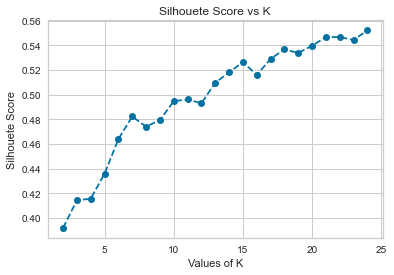

In [186]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('Values of K')
plt.ylabel('Silhouete Score')
plt.title('Silhouete Score vs K')

## 7.2 GMM

In [188]:
gmm_list = []

for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k, random_state=42)  #define quantas guassianas eu quero


    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performance 
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhouete Score vs K')

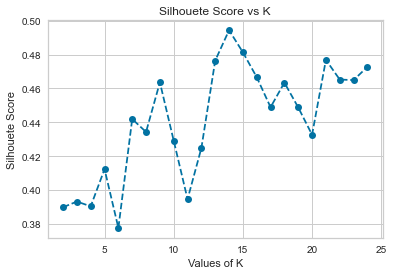

In [189]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('Values of K')
plt.ylabel('Silhouete Score')
plt.title('Silhouete Score vs K')

## 7.3 Hierarchical Clustering

In [191]:
#model deinition and training
hc_model = hc.linkage(X,'ward')

In [192]:
#hc.dendrogram( hc_model, leaf_rotation=90, leaf_font_size=8)
#plt.plot()

In [193]:
hc_list = []
for k in clusters:
    #model definition and training
    hc_model = hc.linkage(X,'ward')
    
    #model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    #metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

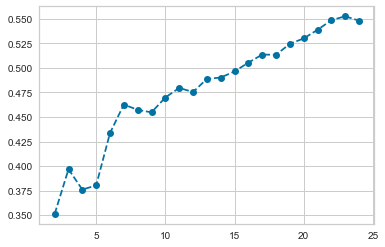

In [194]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')


## 7.5 Results

In [195]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.392040,0.414434,0.415739,0.436017,0.464054,0.482397,0.474176,0.479434,0.494833,0.496230,0.493119,0.509730,0.518157,0.526506,0.516056,0.529013,0.536900,0.533896,0.539790,0.546750,0.546868,0.544387,0.552339
GMM,0.389857,0.393221,0.390412,0.412332,0.377664,0.441911,0.434281,0.463580,0.429119,0.394612,0.424829,0.476431,0.494317,0.481319,0.466605,0.448887,0.463408,0.448748,0.432631,0.476832,0.465218,0.464893,0.472703
HC,0.351220,0.396719,0.375998,0.380294,0.433638,0.462655,0.457264,0.454711,0.469823,0.479593,0.475395,0.488732,0.490180,0.496378,0.505378,0.513563,0.513351,0.524551,0.530033,0.538812,0.548608,0.552632,0.548118


# 8.0 Model Training

## 8.1 k-Means

In [202]:
#model definition
k = 7
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model trainning
kmeans.fit(X)

#clustering
labels = kmeans.labels_
#labels = kmeans.fit_predict(X) #tirar o fit de cima

## 8.2 Cluster Validation

In [203]:
#SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.4814896285533905


# 9.0 Cluster Analysis

In [204]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,12.932047,14.670385,6
1,7.626834,11.938689,6
2,12.472446,14.325506,6
3,-3.743209,7.794079,4
4,20.547087,-8.334893,2


## 9.1 Visualization Inspection

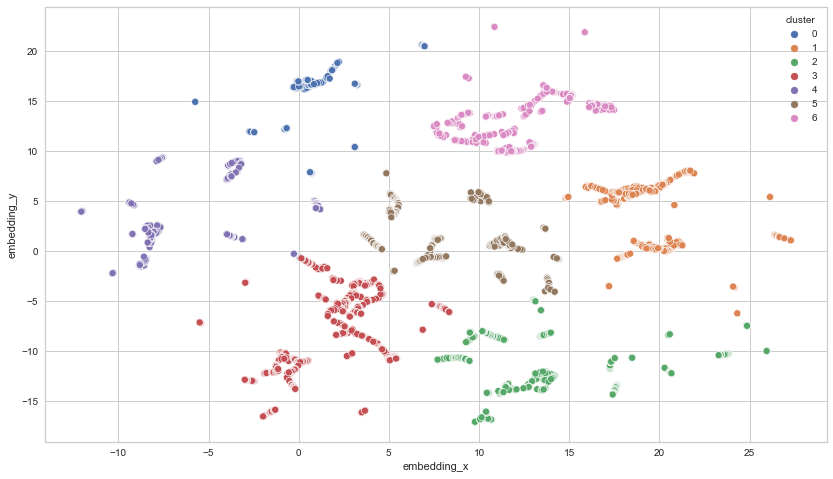

In [205]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

## 9.2 Cluster Profile

In [214]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,0.073171,22.0,26.666667,0.333333


In [206]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,6
1,13047,3232.59,56.0,171.0,0.028302,35.0,6
2,12583,6705.38,2.0,232.0,0.040323,50.0,6
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,2


In [207]:
#Number customer
df_cluster = df92.groupby('cluster').customer_id.count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

#Avg Gross Revenue
df_avg_gross_revenue = df92.groupby('cluster').gross_revenue.mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#Avg Recency Days
df_avg_recency_days = df92.groupby('cluster').recency_days.mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

#Avg invoice_no
df_qtde_products = df92.groupby('cluster').qtde_products.mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

#Frequency
df_frequency = df92.groupby('cluster').frequency.mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

#Returns
df_qtde_returns = df92.groupby('cluster').qtde_returns.mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_returns, how='inner', on='cluster')


df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
6,6,959,16.839333,6199.214442,63.728884,310.589155,0.287675,162.437956
1,1,882,15.487270,1898.699603,116.240363,117.566893,0.480708,2.614512
0,0,350,6.145742,1038.649571,84.488571,66.028571,0.290053,4.045714
4,4,679,11.922739,978.305744,76.977909,41.721649,0.224075,6.273932
5,5,866,15.206321,948.999607,130.284065,57.961894,0.755643,7.361432
2,2,848,14.890255,390.537182,135.020047,10.168632,0.491662,4.551887
3,3,1111,19.508341,273.455005,173.810981,13.986499,0.982890,3.670567


# 10.0 EDA

In [208]:
df10 = df92.copy()

### H1. Os clientes do cluster insiders possuem um volume de compra de produtos acima de 10% do totatl de compras
verdadeiro: O cluster insider possui um volume de compra de 54%

In [210]:
#df10[df10['cluster'] ==1].groupby('cluster').qtde_products.sum().reset_index()

#sum the quantity of products of insiders
df_sales_insiders = df10[df10['cluster'] == 6].qtde_products.sum() #substituir depois o cluster correspondente ao insiders
df_sales_total = df10.qtde_products.sum()

#percentage of sales of insiders by the total product sales
print('% Sales Insiders: {:.2f}'.format(100*df_sales_insiders/df_sales_total))

% Sales Insiders: 56.48


### H2. Os clientes do cluster insiders possuem um volume de faturamento de compras acima de 10% do total de compras
verdadeiro: O cluster insider possui um volume de gmv de 52%

In [211]:
#sum the gmv of insiders
df_gmv_insiders = df10[df10['cluster'] == 6].gross_revenue.sum() #substituir depois o cluster correspondente ao insiders
df_gmv_total = df10.gross_revenue.sum()

#percentage of sales of insiders by the tot/al product sales
print('% Sales Insiders: {:.2f}'.format(100*df_gmv_insiders/df_gmv_total))

% Sales Insiders: 58.84


### H3. Os clientes do cluster insiders tem numero de devolução médio abaixo do media da base total de clientes
Falso: O cluster insiders tem a média de devolução acima da média geral

In [212]:
df_avg_return_insiders = df10[df10['cluster'] == 6].qtde_returns.mean()
df_avg_return_total = df10.qtde_returns.mean()

print('Avg Return insiders: {} vs Avg Returns total: {}'.format(np.round(df_avg_return_insiders, 0),
                                                               np.round(df_avg_return_total, 0)))

Avg Return insiders: 162.0 vs Avg Returns total: 31.0


### H4. A mediana do faturamento pelos clientes do cluster insider é 10% do que a mediana do faturamento geral
verdadeiro: A mediana do faturamento é 279% acima da mediana

In [213]:
#mediana de gmv do insiders
df_median_gmv_insiders = df10[df10['cluster'] == 6].gross_revenue.median()

#mediana de gmv do total
df_median_gmv_total = df10.gross_revenue.median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total
print('Median Diff: {:.2f}%'.format(100*gmv_diff))

Median Diff: 368.08%


### H5. O GMV dos clientes insiders está concentradas no 3 quartil 
Falso: O faturamento do cluster insiders esta concentrada no quartil 1 


In [201]:
np.percentile(df10[df10['cluster'] == 3].gross_revenue, q=0.1)

429.79439999999994

In [202]:
np.percentile(df10[df10['cluster'] == 3].gross_revenue, q=0.9)

434.3448

<AxesSubplot:xlabel='gross_revenue'>

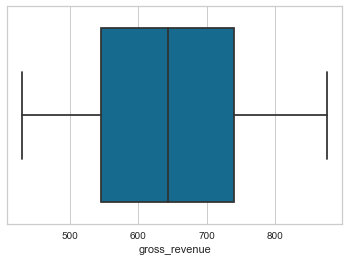

In [212]:
df_aux = (df10[(df10['cluster'] == 3) & 
               (df10['gross_revenue'] < 10000)]
               .gross_revenue)
sns.boxplot(x=df_aux)

<AxesSubplot:xlabel='gross_revenue'>

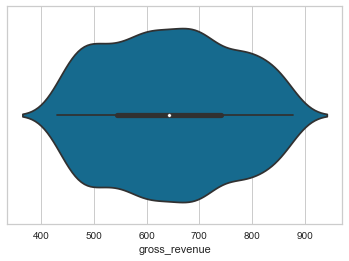

In [211]:
df_aux = (df10[(df10['cluster'] == 3) &
               (df10['gross_revenue'] < 10000)]
               .gross_revenue)
sns.violinplot(x=df_aux)